<a href="https://colab.research.google.com/github/myidispg/deep_learning_specialization/blob/master/CNN/Week%201/Tensorflow_cifar_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook serves to demostrate the use of CNN on CIFAR 10 dataset

Dataset: https://www.cs.toronto.edu/~kriz/cifar.html


In [0]:
import matplotlib.pyplot as plt
# To display images inline with the Jupyter Notebook.
%matplotlib inline

import numpy as np
import pandas as pd

# For downloading and extracting the .tar files in the dataset
import os
import tarfile
import urllib
import requests

# For image related tasks.
from PIL import Image

import tensorflow as tf

##Create a folder for the cifar 10 dataset.

In [2]:
!mkdir cifar_data
!ls

mkdir: cannot create directory ‘cifar_data’: File exists
cifar_data  sample_data


##Check and see if the data download is required.

The below code will download the data if it doesn't exist in the path: 

```
cifar_data/cifar-10-python.tar.gz
```

If the data exists, dowmload is skipped. Else, the data is downloaded.

**Note**: There could be errors where a file exists but it is corrupted or some other issues like incomplete downloads. In such cases, please remove the file and download run the folowing cell again to download the dataset.



In [3]:
dataset_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

print('Checking if data exists...')

if os.path.basename(dataset_url) in os.listdir('cifar_data/'):
  print('Skipping data download. It already exists.')
else:
  print('Downloading data...')
  r = requests.get(dataset_url)

  with open(f'cifar_data/{os.path.basename(dataset_url)}', 'wb') as file:
    file.write(r.content)
  print('Data downloaded!')
  
tarfile_path = f'cifar_data/{os.path.basename(dataset_url)}'

Checking if data exists...
Skipping data download. It already exists.


##Extract the files from the tarfile.

The tarfile contains contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle.

The extracted files will be stored in the directory: ```cifar_data/cifar-10-batches_py/```

In [4]:
tfile = tarfile.open(tarfile_path)

print('The tarfile has the following members.')
print(tfile.getnames())
print('Extracting all the members...')
tfile.extractall('cifar_data/')
print('Extraction complete.')

The tarfile has the following members.
['cifar-10-batches-py', 'cifar-10-batches-py/data_batch_4', 'cifar-10-batches-py/readme.html', 'cifar-10-batches-py/test_batch', 'cifar-10-batches-py/data_batch_3', 'cifar-10-batches-py/batches.meta', 'cifar-10-batches-py/data_batch_2', 'cifar-10-batches-py/data_batch_5', 'cifar-10-batches-py/data_batch_1']
Extracting all the members...
Extraction complete.


##The unpickle() method reads the batches file and returns a dictionary.

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

flag = True # A flag to track whether to create keys of append to existing keys.
dictionary = dict()

for batch in os.listdir('cifar_data/cifar-10-batches-py'):
  if batch not in ['batches.meta', 'readme.html', 'test_batch']:
    
    dictionary_raw = unpickle(f'cifar_data/cifar-10-batches-py/{batch}')
    if flag: # Create keys.
      # ^^ Reshape images to 32x32x3 format.
      dictionary['labels'] = dictionary_raw[b'labels']
      dictionary['data'] = dictionary_raw[b'data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1) 
      flag = not flag # Now, the data will be appended to the created keys.
    else:
      dictionary['labels'] += dictionary_raw[b'labels']
      dictionary['data'] = np.concatenate((dictionary['data'], dictionary_raw[b'data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1)))

# Get the test data too.

In [0]:
test_dictionary = dict()
dictionary_raw = unpickle('cifar_data/cifar-10-batches-py/test_batch')

test_dictionary['labels'] = dictionary_raw[b'labels']
test_dictionary['data'] = dictionary_raw[b'data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1) # Reshape images to 32x32x3 format.

## Some constants and the label data.

In [0]:
train_size = 40000
valid_size = 10000
test_size = 10000
im_height = 32
im_width = 32
num_channels = 3
num_classes = 10

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## To see if everything is in order, display some images randomly and their corresponding labels.

I will display 10 images and their labels from randomly generated indexes.

'Visually, we can determine that the loading of data into dictionaries has been done correctly.'

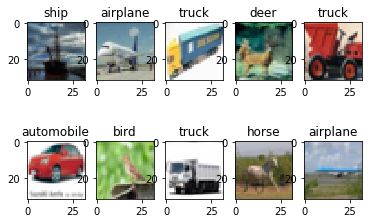

In [8]:
f, axarr = plt.subplots(2, 5)

for i in range(2):
  for j in range(5):
    index = np.random.randint(0, train_size)
    axarr[i, j].imshow(dictionary['data'][index])
    axarr[i, j].set_title(label_names[dictionary['labels'][index]])

"""Visually, we can determine that the loading of data into dictionaries has been done correctly."""

## Convert the dictionaries to numpy arrays.

In [0]:
train_images = np.asarray(dictionary['data'])
train_labels = np.asarray(dictionary['labels'])

test_images = np.asarray(test_dictionary['data'])
test_labels = np.asarray(test_dictionary['labels'])

## Perform some cleanup. 

Though this is not required, I would like to get rid of some unused things.

In [10]:
import gc

del dictionary_raw, dictionary, test_dictionary, tfile
gc.collect()

37

# Now, moving on to some pre processing.

The pre processing will include normalization and one hot encoding.

###Normalization

I am going to use **Min-Max Normalization** `(y = (x-min) / (max-min))`,but there are other options too. 
By applying Min-Max normalization, the original image data is going to be transformed in range of 0 to 1 (inclusive). 

In [0]:
def normalize(x):
  
  x = (x-np.min(x))/ (np.max(x) - np.min(x))
  
  return x

train_images = normalize(train_images)
test_images = normalize(test_images)

###One Hot Encode the labels.

In [12]:
def one_hot_encode(Y, C):
  encoded = np.zeros((len(Y), C))
  
  for idx, val in enumerate(Y):
    encoded[idx][val] = 1
  
  return encoded

train_labels = one_hot_encode(train_labels, num_classes)
test_labels = one_hot_encode(test_labels, num_classes)

# # Split into validation and train split
# validation_images = train_images[train_size:, :]
# validation_labels = train_labels[train_size:, :]

train_images = train_images[:train_size, :]
train_labels = train_labels[:train_size, :]

print(f'The shape of training data: {train_images.shape}')
print(f'The shape of training labels: {train_labels.shape}')
# print(f'The shape of validation data: {validation_images.shape}')
# print(f'The shape of validation labels: {validation_labels.shape}')
print(f'The shape of test images: {test_images.shape}')
print(f'The shape of test labels: {test_labels.shape}')

The shape of training data: (40000, 32, 32, 3)
The shape of training labels: (40000, 10)
The shape of test images: (10000, 32, 32, 3)
The shape of test labels: (10000, 10)


##Function to split the data into mini_batches

In [0]:
def get_mini_batches(X, Y, mini_batch_size):
  m = X.shape[0] # number of examples
  mini_batches = []
  
  # Shuffle X and Y
  shuffles = list(np.random.permutation(m))
  shuffled_X = X[shuffles, :, :, :]
  shuffled_Y = Y[shuffles,:]
  
  # Partition the shuffles batches but exclude the end case.
  num_complete_minibatches = m//mini_batch_size
  for k in range(num_complete_minibatches):
    mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
    mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)
    
  if m % mini_batch_size != 0:
    mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
    mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)
    
  return mini_batches

### Declare some hyper parameters for the model training process.

In [0]:
epochs = 100
keep_probability = 0.8
learning_rate = 0.001
batch_size = 128

# Define the model

### I am going to be using the Le Net architecture.

The architecture **is** detailed here: https://medium.com/datadriveninvestor/five-powerful-cnn-architectures-b939c9ddd57b

####LeNet-5 — LeCun et al
LeNet-5, a 7 layer Convolutional Neural Network, was deployed in many banking systems to recognize hand-written numbers on cheques.


---


![LeNet-5 Architecture](https://cdn-images-1.medium.com/max/1200/1*avmwxTth2efzRlvSr6MaKg.jpeg)
LeNet-5 — Architecture


---


The model contains 7 layers excluding the input layer. Since it is a relatively small architecture, let’s go layer by layer:

**Layer 1**: A convolutional layer with kernel size of 5×5, stride of 1×1 and 6 kernels in total. So the input image of size 32x32x1 gives an output of 28x28x6. Total params in layer = 5 * 5 * 6 + 6 (bias terms)

**Layer 2**: A pooling layer with 2×2 kernel size, stride of 2×2 and 6 kernels in total. This pooling layer acted a little differently than what we discussed in previous post. The input values in the receptive were summed up and then were multiplied to a trainable parameter (1 per filter), the result was finally added to a trainable bias (1 per filter). Finally, sigmoid activation was applied to the output. So, the input from previous layer of size 28x28x6 gets sub-sampled to 14x14x6. Total params in layer = [1 (trainable parameter) + 1 (trainable bias)] * 6 = 12

**Layer 3**: Similar to Layer 1, this layer is a convolutional layer with same configuration except it has 16 filters instead of 6. So the input from previous layer of size 14x14x6 gives an output of 10x10x16. Total params in layer = 5 * 5 * 16 + 16 = 416.

**Layer 4**: Again, similar to Layer 2, this layer is a pooling layer with 16 filters this time around. Remember, the outputs are passed through sigmoid activation function. The input of size 10x10x16 from previous layer gets sub-sampled to 5x5x16. Total params in layer = (1 + 1) * 16 = 32

**Layer 5**: This time around we have a convolutional layer with 5×5 kernel size and 120 filters. There is no need to even consider strides as the input size is 5x5x16 so we will get an output of 1x1x120. Total params in layer = 5 * 5 * 120 = 3000

**Layer 6**: This is a dense layer with 84 parameters. So, the input of 120 units is converted to 84 units. Total params = 84 * 120 + 84 = 10164. The activation function used here was rather a unique one. I’ll say you can just try out any of your choice here as the task is pretty simple one by today’s standards.

**Output Layer**: Finally, a dense layer with 10 units is used. Total params = 84 * 10 + 10 = 924.

In [0]:
X = tf.placeholder(tf.float32, shape=(None, im_height, im_width, num_channels), name='input_x')
Y = tf.placeholder(tf.float32, shape=(None, num_classes), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob') # Shape can be found automatically.

def model(x, keep_prob):
  filter1 = tf.get_variable('filter_1', [5, 5, 3, 6], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  filter2 = tf.get_variable('filter_2', [5, 5, 6, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  filter3 = tf.get_variable('filter_3', [5, 5, 16, 256], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  filter4 = tf.get_variable('filter_4', [5, 5, 256, 512], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  
  # Input -> 32x32x3
  conv1 = tf.nn.conv2d(x, filter1, strides=[1,1,1,1], padding='SAME') # Output -> 28x28x6
  conv1 = tf.nn.relu(conv1)
  pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1,2,2,1], padding='SAME') # Output -> 14x14x6
  
  conv2 = tf.nn.conv2d(pool1, filter2, strides=[1, 1, 1, 1], padding='VALID') # Output -> 10x10x16
  conv2 = tf.nn.relu(conv2)
  pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') # Output -> 5x5x16
  
  # Flatten. Input -> 5x5x16, Output -> 400
  flatten = tf.contrib.layers.flatten(pool2)
  
  # Hidden layers
  hidden = tf.contrib.layers.fully_connected(flatten, num_outputs=128, activation_fn=tf.nn.relu)
  hidden = tf.nn.dropout(hidden, keep_prob)
  hidden = tf.layers.batch_normalization(hidden)
  
  hidden = tf.contrib.layers.fully_connected(hidden , num_outputs=64, activation_fn=tf.nn.relu)
  hidden = tf.nn.dropout(hidden, keep_prob)
  hidden = tf.layers.batch_normalization(hidden)
  
  # Output
  output = tf.contrib.layers.fully_connected(hidden, num_outputs=num_classes, activation_fn=None)
  
  
  return output

### Define the cost function and the optimizer.

I am going to be using the Adam Optimizer. The loss function is going to be Softmax Cross Entropy Loss because it is a classification task with more than 2 classes.

In [16]:
logits = model(X, keep_prob)

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Find out the accuracy
correct_pred = tf.equal(tf.argmax(logits, axis = 1), tf.argmax(Y, axis = 1)) # See if the prediction index is same as the label index. 
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

W0618 06:56:00.097050 139625782196096 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0618 06:56:00.135894 139625782196096 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0618 06:56:00.611462 139625782196096 deprecation.py:506] From <ipython-input-15-bc3fa88b55a7>:25: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use 

### Train the model.

I am going to run the model and optimzie over batches.

In [17]:
# # A function to run the graph over a single batch

# def train_network(session, optimizer, keep_prob, input_batch, label_batch):
#   session.run(optimizer, feed_dict={X: input_batch, Y: label_batch, keep_prob:keep_prob})
  
# def print_stats(session, feature_batch, label_batch, cost, accuracy):
#     loss = sess.run(cost, 
#                     feed_dict={
#                         x: feature_batch,
#                         y: label_batch,
#                         keep_prob: 1.
#                     })
#     valid_acc = sess.run(accuracy, 
#                          feed_dict={
#                              x: valid_features,
#                              y: valid_labels,
#                              keep_prob: 1.
#                          })
    
#     print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

SyntaxError: ignored

In [0]:
with tf.Session() as sess:
  # Intializing the variables
  sess.run(tf.global_variables_initializer())
  
  # Training
  for epoch in range(epochs):
    mini_batch_cost = 0
    train_mini_batch_size = train_size // batch_size
#     valid_mini_batch_size = valid_size // batch_size
    test_mini_batch_size = test_size // batch_size  
  
    train_minibatches = get_mini_batches(train_images, train_labels, batch_size)
#     valid_minibatches = get_mini_batches(validation_images, validation_labels, batch_size)
    test_mini_batches = get_mini_batches(test_images, test_labels, batch_size)
    
    for minibatch in train_minibatches:
      (minibatch_X, minibatch_Y) = minibatch
      _, temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, keep_prob: keep_probability})
      
      mini_batch_cost += temp_cost / train_mini_batch_size
      
    for minibatch in test_mini_batches:
      (minibatch_X, minibatch_Y) = minibatch
      acc = sess.run(accuracy, feed_dict={X: minibatch_X, Y: minibatch_Y, keep_prob: 1}) # While validation, we need to make sure that all neurons are activated.
      
    
    print(f'Epoch: {epoch + 1}\t training_loss: {mini_batch_cost}\t validation_accuracy: {acc}')
    

Epoch: 1	 training_loss: 1.8646073746375558	 validation_accuracy: 0.25
Epoch: 2	 training_loss: 1.5548529613476527	 validation_accuracy: 0.625
Epoch: 3	 training_loss: 1.4393082131177954	 validation_accuracy: 0.5625
Epoch: 4	 training_loss: 1.360599303092713	 validation_accuracy: 0.625
Epoch: 5	 training_loss: 1.299765368684745	 validation_accuracy: 0.4375
Epoch: 6	 training_loss: 1.2506610342325304	 validation_accuracy: 0.5
Epoch: 7	 training_loss: 1.2095881545772922	 validation_accuracy: 0.5
Epoch: 8	 training_loss: 1.1702326532357774	 validation_accuracy: 0.625
Epoch: 9	 training_loss: 1.1405601816681714	 validation_accuracy: 0.4375
